# References

https://github.com/cms-sw/cmssw/blob/master/GeneratorInterface/RivetInterface/src/HiggsTemplateCrossSections.cc#L745

https://github.com/cms-sw/cmssw/blob/master/GeneratorInterface/RivetInterface/src/HiggsTemplateCrossSections.cc#L850

https://github.com/cms-sw/cmssw/blob/master/GeneratorInterface/RivetInterface/src/HiggsTemplateCrossSections.cc#L759   

https://github.com/cms-sw/cmssw/blob/master/GeneratorInterface/RivetInterface/src/HiggsTemplateCrossSections.cc#L856

Jennet: https://github.com/jennetd/hbb-coffea/blob/stocknano/vbf-scripts/make-hists-stxs.py#L51-L52

In [1]:
import argparse
import json
import os
import pickle as pkl
import sys, glob
import time
import warnings
from typing import Union

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import uproot
from coffea import nanoevents, processor
from coffea.nanoevents import BaseSchema, NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods.nanoaod import FatJetArray, GenParticleArray

sys.path.append("../")

import json
import os
import pathlib
import pickle as pkl
import shutil
import warnings
from collections import defaultdict
from typing import List, Optional

import awkward as ak
import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from coffea import processor
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents.methods import candidate, vector

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid="ignore")

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/numba/cpython/hashing.py:482: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [53]:
! ls ../eos/rivet/Dec20_hww_rivet_2017/GluGluHToWW_Pt-200ToInf_M-125_Rivet/outfiles

0-2.pkl          2-4_ele.parquet  4-6_mu.parquet   8-10.pkl
0-2_ele.parquet  2-4_mu.parquet   6-8.pkl          8-10_ele.parquet
0-2_mu.parquet   4-6.pkl          6-8_ele.parquet  8-10_mu.parquet
2-4.pkl          4-6_ele.parquet  6-8_mu.parquet


In [5]:
! ls ../eos/Dec20_hww_2017/VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil//outfiles

0-2.pkl           2-4_ele.parquet   30-32_mu.parquet  42-44.pkl
0-2_ele.parquet   2-4_mu.parquet    32-34.pkl         42-44_ele.parquet
0-2_mu.parquet    20-22.pkl         32-34_ele.parquet 42-44_mu.parquet
10-12.pkl         20-22_ele.parquet 32-34_mu.parquet  44-46.pkl
10-12_ele.parquet 20-22_mu.parquet  34-36.pkl         44-46_ele.parquet
10-12_mu.parquet  22-24.pkl         34-36_ele.parquet 44-46_mu.parquet
12-14.pkl         22-24_ele.parquet 34-36_mu.parquet  46-48.pkl
12-14_ele.parquet 22-24_mu.parquet  36-38.pkl         46-48_ele.parquet
12-14_mu.parquet  24-26.pkl         36-38_ele.parquet 46-48_mu.parquet
14-16.pkl         24-26_ele.parquet 36-38_mu.parquet  48-50.pkl
14-16_ele.parquet 24-26_mu.parquet  38-40.pkl         48-50_ele.parquet
14-16_mu.parquet  26-28.pkl         38-40_ele.parquet 48-50_mu.parquet
16-18.pkl         26-28_ele.parquet 38-40_mu.parquet  6-8.pkl
16-18_ele.parquet 26-28_mu.parquet  4-6.pkl           6-8_ele.parquet
16-18_mu.parquet  28-30.pkl         4-6_

In [57]:
import scipy
def get_finetuned_score(data, model_path):
    import onnx
    import onnxruntime as ort

    input_dict = {
        "highlevel": data.loc[:, "fj_ParT_hidNeuron000":"fj_ParT_hidNeuron127"].values.astype("float32"),
    }

    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)

    ort_sess = ort.InferenceSession(
        model_path,
        providers=["AzureExecutionProvider"],
    )
    outputs = ort_sess.run(None, input_dict)

    return scipy.special.softmax(outputs[0], axis=1)[:, 0]

In [58]:
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)["ele"]["2017"]

def get_sum_sumgenweight(pkl_files, year, sample):
    """Load and sum the sumgenweight of each pkl file."""

    sum_sumgenweight = 0
    for ifile in pkl_files:
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]

    return sum_sumgenweight

def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    """Get xsec-weight and scales events by lumi/sumgenweights."""

    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [69]:
channels = [
    "ele",
    "mu",
]

samples = [
    "ggF",
    "VBF",
]

samples_dict = {
    "ggF": "GluGluHToWW_Pt-200ToInf_M-125_Rivet",
    "VBF": "VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil_Rivet",
}

samples_dir = "../eos/Dec20_hww"
year = "2017"

In [70]:
df = {}

for sample in samples:
    df[sample] = {}
    for ch in channels:

        df[sample][ch] = pd.read_parquet(glob.glob(f"{samples_dir}_{year}/{samples_dict[sample]}/outfiles/*_{ch}.parquet"))

        df[sample][ch]["THWW"] = get_finetuned_score(df[sample][ch], "../../weaver-core-dev/experiments_finetuning/v35_30/model.onnx")    
        
        # apply missing selection to skim a bit
        msk = ( df[sample][ch]["fj_pt"]>250 ) & ( df[sample][ch]["lep_fj_dr"]>0.03 ) & ( df[sample][ch]["lep_fj_dr"]<0.8 ) & ( df[sample][ch]["met_pt"]>20 ) & ( np.abs(df[sample][ch]["met_fj_dphi"])<1.57 ) & ( np.abs(df[sample][ch]["n_bjets_T"])==0 )
        
        msk2 = (df[sample][ch]["THWW"]>0.905)
        df[sample][ch] = df[sample][ch][msk & msk2]

        # get nominal weight
        pkl_files = glob.glob(f"{samples_dir}_{year}/{samples_dict[sample]}/outfiles/*.pkl")
        
        df[sample][ch]["xsecweight"] = get_xsecweight(pkl_files, "2017", samples_dict[sample], False, luminosity)        
        df[sample][ch]["nominal"] = df[sample][ch]["xsecweight"] * df[sample][ch][f"weight_{ch}"]

In [84]:
for key in df["ggF"]["lep"]:
    if "STXS" in key:
        print(key)

STXS_Higgs_pt
STXS_cat
STXS_finecat


In [139]:
# combine channels
for sample in samples:
    l = []
    for ch in channels:
        l += [df[sample][ch]]
        
    df[sample]["lep"] = pd.concat(l)
    
# combine signal
l = []
for sample in samples:
    l += [df[sample]["lep"]]

df["sig"] = pd.concat(l)

Text(0.5, 1.0, 'ggF')

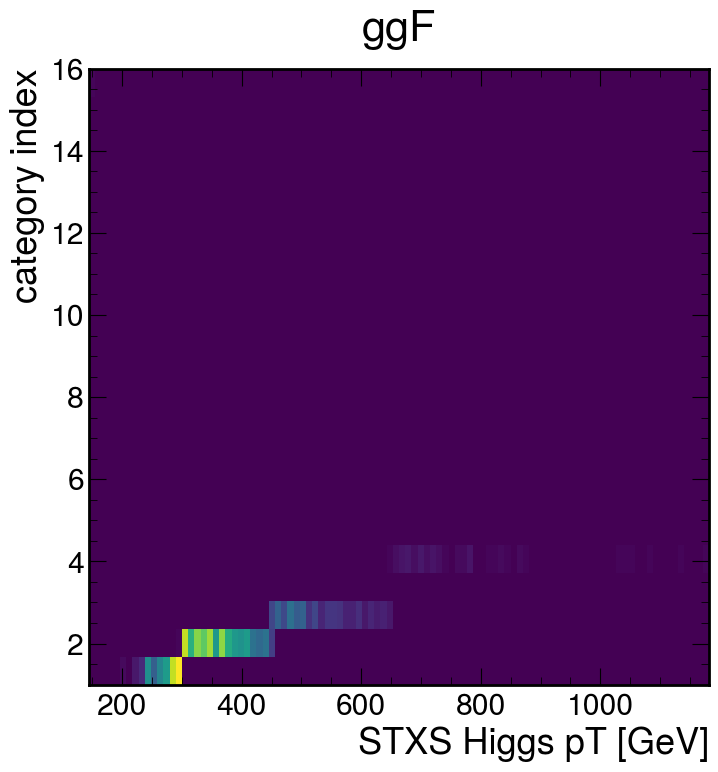

In [75]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist2d(
    df["ggF"]["lep"]["STXS_Higgs_pt"],
    df["ggF"]["lep"]["STXS_cat"] % 100,
    bins=(100,22),
)

ax.set_xlabel("STXS Higgs pT [GeV]")
ax.set_ylabel("category index")
ax.set_title("ggF", pad=20)

Text(0.5, 1.0, 'ggF')

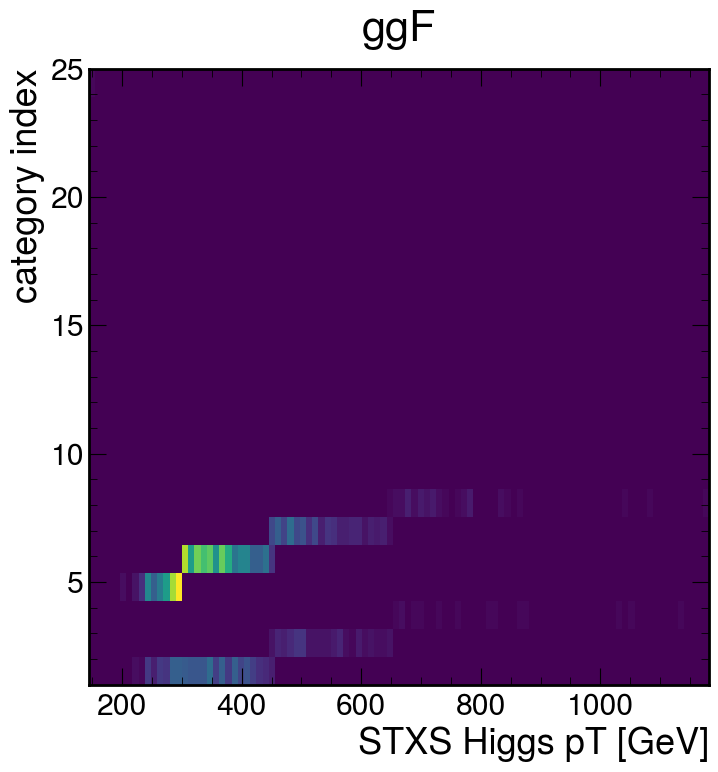

In [76]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist2d(
    df["ggF"]["lep"]["STXS_Higgs_pt"],
    df["ggF"]["lep"]["STXS_finecat"] % 100,
    bins=(100,22),
)

ax.set_xlabel("STXS Higgs pT [GeV]")
ax.set_ylabel("category index")
ax.set_title("ggF", pad=20)

Text(0.5, 1.0, 'ggF')

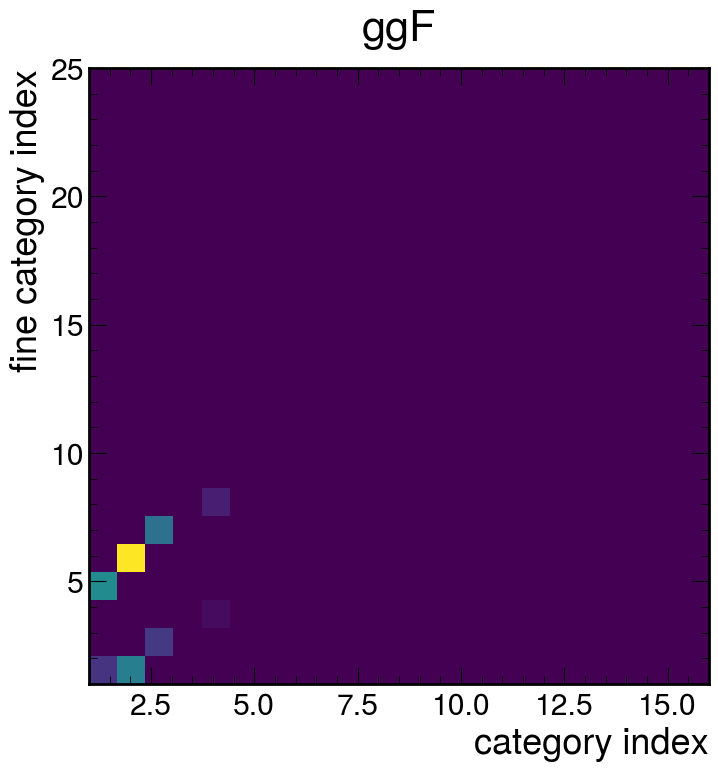

In [77]:
fig, ax = plt.subplots(figsize=(8,8))

ax.hist2d(
    df["ggF"]["lep"]["STXS_cat"] % 100,
    df["ggF"]["lep"]["STXS_finecat"] % 100,
    bins=(22,22),
)

ax.set_xlabel("category index")
ax.set_ylabel("fine category index")
ax.set_title("ggF", pad=20)

In [112]:
yticks_reversed = {
    "ggF": [
        "GG2H_FWDH",
        "GG2H_PTH_200_300_PTHJoverPTH_0_15",
        "GG2H_PTH_300_450_PTHJoverPTH_0_15",
        "GG2H_PTH_450_650_PTHJoverPTH_0_15",
        "GG2H_PTH_GT650_PTHJoverPTH_0_15",
        "GG2H_PTH_200_300_PTHJoverPTH_GT15",
        "GG2H_PTH_300_450_PTHJoverPTH_GT15",
        "GG2H_PTH_450_650_PTHJoverPTH_GT15",
        "GG2H_PTH_GT650_PTHJoverPTH_GT15",
        "GG2H_0J_PTH_0_10",
        "GG2H_0J_PTH_GT10",
        "GG2H_1J_PTH_0_60",
        "GG2H_1J_PTH_60_120",
        "GG2H_1J_PTH_120_200",
        "GG2H_GE2J_MJJ_0_350_PTH_0_60_PTHJJ_0_25",
        "GG2H_GE2J_MJJ_0_350_PTH_60_120_PTHJJ_0_25",
        "GG2H_GE2J_MJJ_0_350_PTH_120_200_PTHJJ_0_25",
        "GG2H_GE2J_MJJ_0_350_PTH_0_60_PTHJJ_GT25",
        "GG2H_GE2J_MJJ_0_350_PTH_60_120_PTHJJ_GT25",
        "GG2H_GE2J_MJJ_0_350_PTH_120_200_PTHJJ_GT25",
        "GG2H_GE2J_MJJ_350_700_PTH_0_200_PTHJJ_0_25",
        "GG2H_GE2J_MJJ_350_700_PTH_0_200_PTHJJ_GT25",
        "GG2H_GE2J_MJJ_700_1000_PTH_0_200_PTHJJ_0_25",
        "GG2H_GE2J_MJJ_700_1000_PTH_0_200_PTHJJ_GT25",
        "GG2H_GE2J_MJJ_1000_1500_PTH_0_200_PTHJJ_0_25",
        "GG2H_GE2J_MJJ_1000_1500_PTH_0_200_PTHJJ_GT25",
        "GG2H_GE2J_MJJ_GT1500_PTH_0_200_PTHJJ_0_25",
        "GG2H_GE2J_MJJ_GT1500_PTH_0_200_PTHJJ_GT25",
    ],
    "VBF": [
        "QQ2HQQ_FWDH",
        "QQ2HQQ_0J",
        "QQ2HQQ_1J",
        "QQ2HQQ_GE2J_MJJ_0_60_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_60_120_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_120_350_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_0_60_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_60_120_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_120_350_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_350_700_PTH_0_200_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_350_700_PTH_0_200_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_700_1000_PTH_0_200_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_700_1000_PTH_0_200_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_1000_1500_PTH_0_200_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_1000_1500_PTH_0_200_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_GT1500_PTH_0_200_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_GT1500_PTH_0_200_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_350_700_PTH_GT200_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_350_700_PTH_GT200_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_700_1000_PTH_GT200_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_700_1000_PTH_GT200_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_1000_1500_PTH_GT200_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_1000_1500_PTH_GT200_PTHJJ_GT25",
        "QQ2HQQ_GE2J_MJJ_GT1500_PTH_GT200_PTHJJ_0_25",
        "QQ2HQQ_GE2J_MJJ_GT1500_PTH_GT200_PTHJJ_GT25",
    ],
}

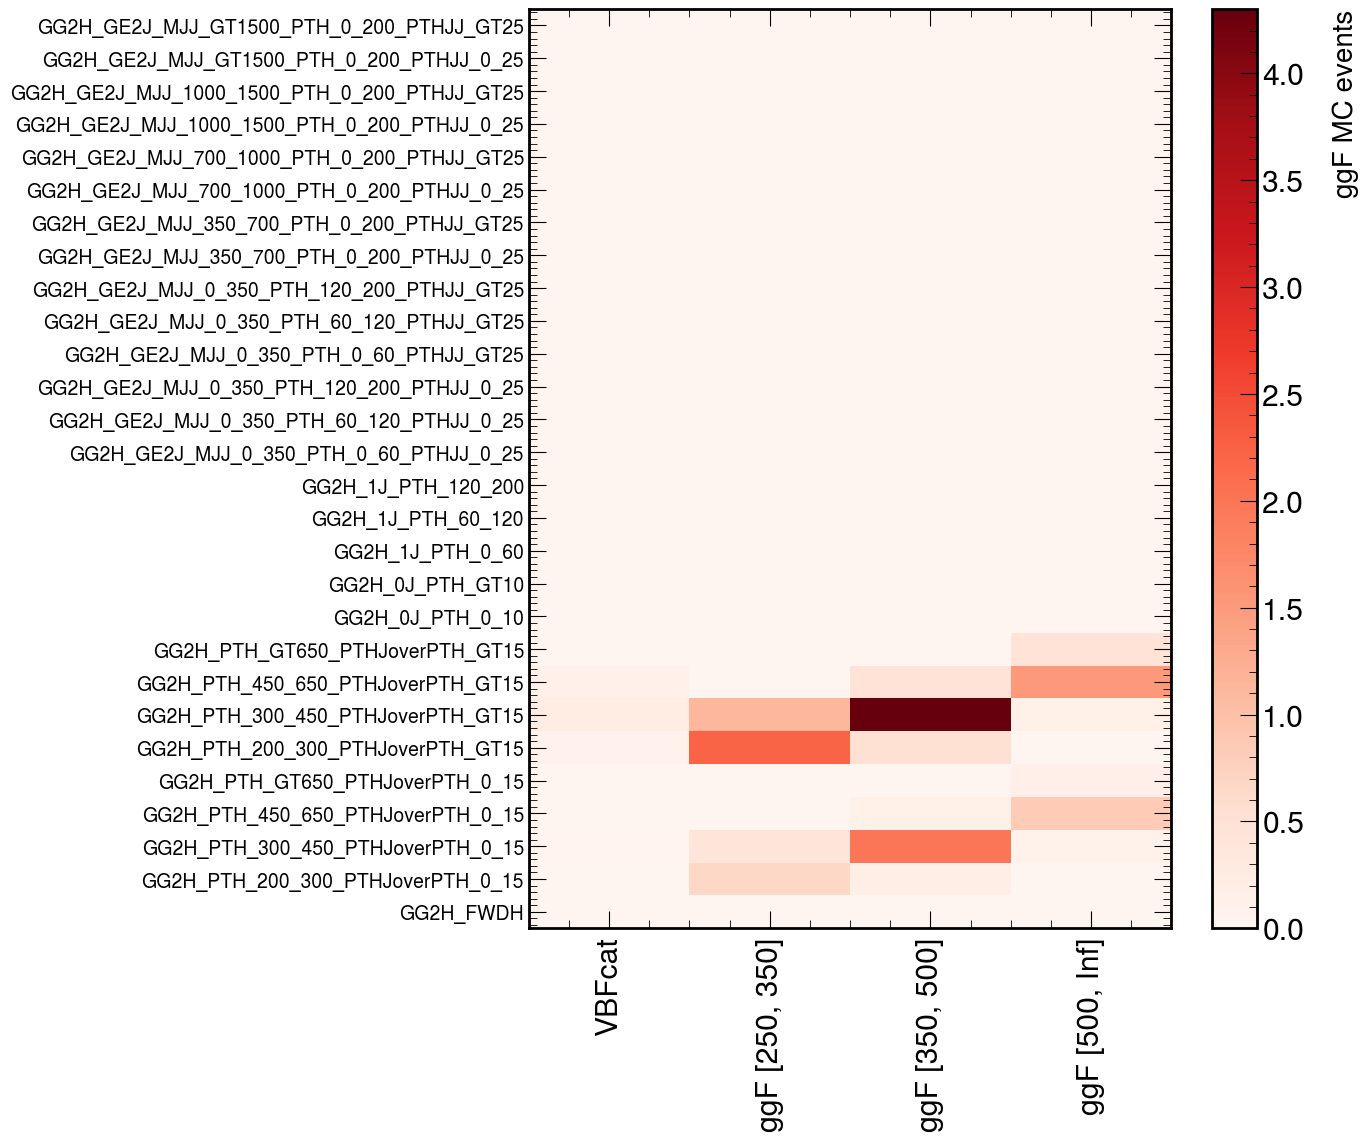

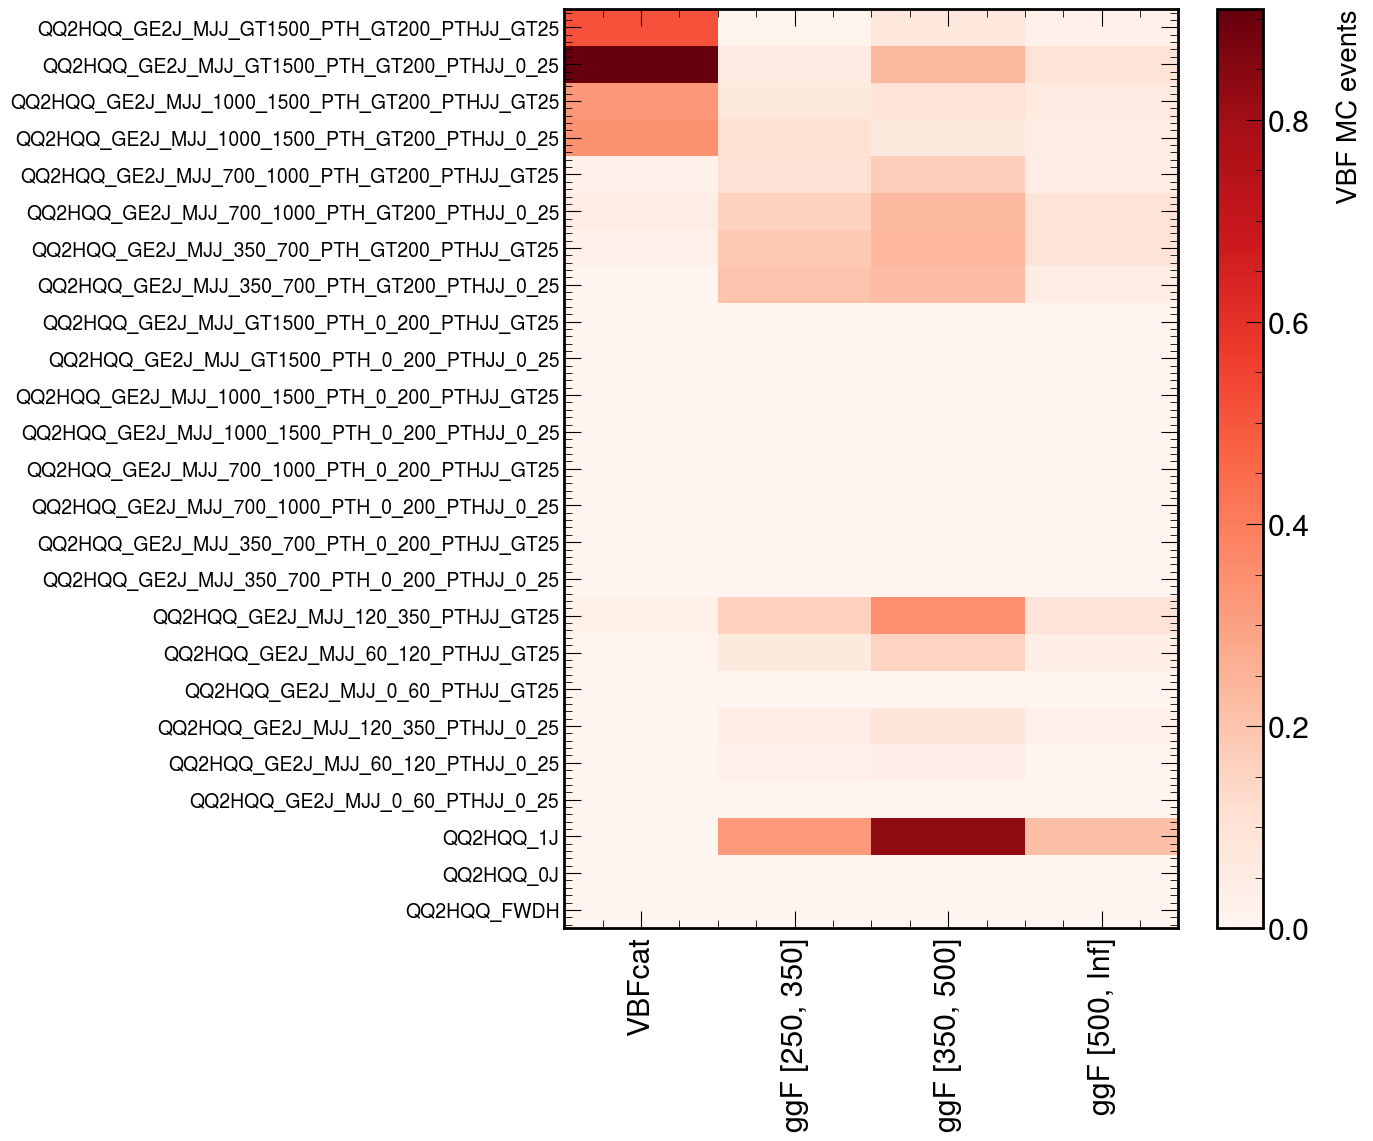

In [175]:
for sample in [
    "ggF",
    "VBF",
]:

    cut_mjjdeta_VBF = (df[sample]["lep"]["mjj"] > 1000) & (df[sample]["lep"]["deta"] > 3.5)
    cut_mjjdeta_ggF = ~cut_mjjdeta_VBF
    
    # initialize a new column called recobin
    df[sample]["lep"]["recobin"] = -1

    # add VBF category index as 0
    df[sample]["lep"].loc[cut_mjjdeta_VBF, "recobin"] = 0
    
    # add ggF category index as 1,2,3
    shift = 50
    recobin_cut_dict = {
        "1": (250, 300 + shift),
        "2": (300 + shift, 450 + shift),
        "3": (450 + shift, 2500),
    }

    for index, ptcut in recobin_cut_dict.items():

        cut_pt = (df[sample]["lep"]["rec_higgs_pt"] > ptcut[0]) & (df[sample]["lep"]["rec_higgs_pt"] < ptcut[1])
        
        df[sample]["lep"].loc[cut_mjjdeta_ggF & cut_pt, "recobin"] = int(index)
 
    fig, ax = plt.subplots(figsize=(14,12))

    # Create the 2D histogram
    h = ax.hist2d(
        df[sample]["lep"]["recobin"],
        df[sample]["lep"]["STXS_finecat"] % 100,
        bins=(4, range(len(yticks_reversed[sample]) + 1)),
        cmap="Reds",
        weights=df[sample]["lep"]["nominal"],
    )

    # Customize x-axis ticks to be in the middle of the bins
    ax.set_xlim(0, 3)    
    cell_length = 3/4
    bin_centers = [cell_length/2, 2*cell_length - cell_length/2, 3*cell_length - cell_length/2, 4*cell_length -cell_length/2]

    ax.set_xticks(bin_centers)

    ax.set_xticklabels(["VBFcat", f"ggF [250, {300+shift}]", f"ggF [{300+shift}, {450+shift}]", f"ggF [{450+shift}, Inf]"], rotation=90)

    # Add a colorbar
    cbar = fig.colorbar(h[3], ax=ax)
    cbar.set_label(f"{sample} MC events", labelpad=20, fontsize=20)  # Label for the colorbar

    ytick_positions = [i + 0.5 for i in range(len(yticks_reversed[sample]))]  # Center of each bin
    ax.set_yticks(ytick_positions)
    ax.set_yticklabels(yticks_reversed[sample], fontsize=14)

    plt.tight_layout()

    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/STXS/{sample}_migration_matrix.pdf")       

In [122]:
np.unique(df[sample]["lep"]["recobin"], return_counts=True)

(array([0, 1, 2, 3]), array([195, 129, 227,  74]))

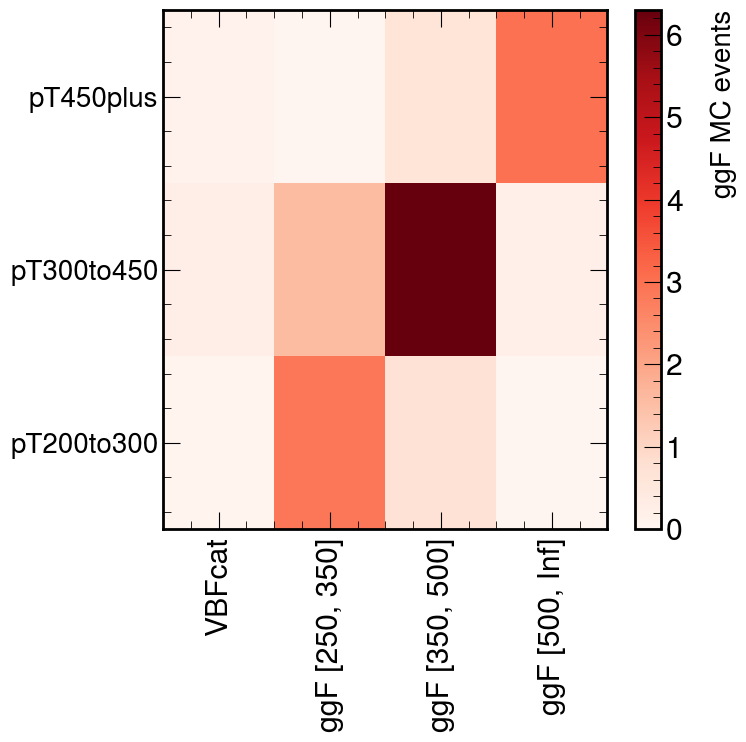

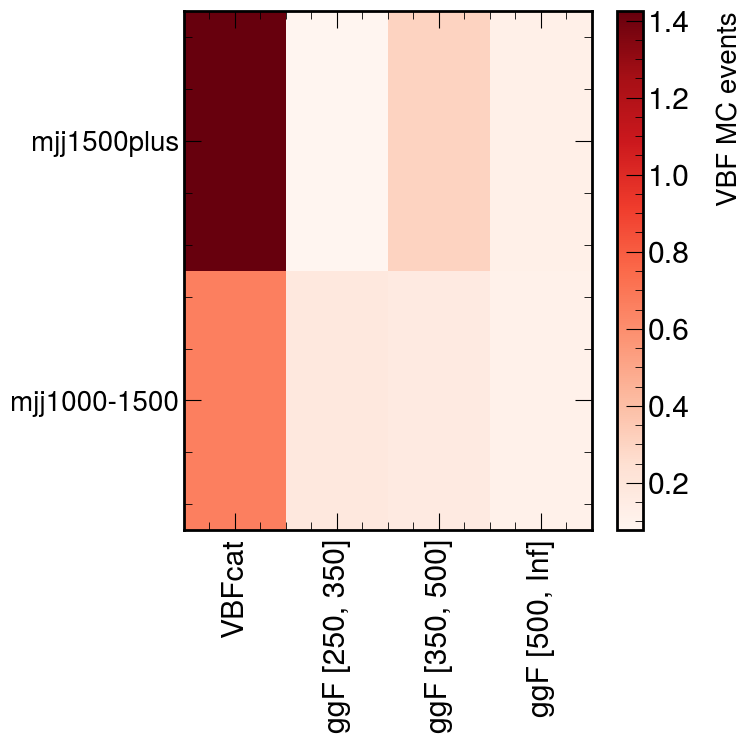

In [176]:
df["ggF"]["lep"]["STXS_finecat_simplified"] = -1
df["ggF"]["lep"].loc[( (df["ggF"]["lep"]["STXS_finecat"] % 100 == 1) | (df["ggF"]["lep"]["STXS_finecat"] % 100 == 5) ), "STXS_finecat_simplified"] = 0
df["ggF"]["lep"].loc[( (df["ggF"]["lep"]["STXS_finecat"] % 100 == 2) | (df["ggF"]["lep"]["STXS_finecat"] % 100 == 6) ), "STXS_finecat_simplified"] = 1
df["ggF"]["lep"].loc[( (df["ggF"]["lep"]["STXS_finecat"] % 100 == 3) | (df["ggF"]["lep"]["STXS_finecat"] % 100 == 7) | (df["ggF"]["lep"]["STXS_finecat"] % 100 == 4) | (df["ggF"]["lep"]["STXS_finecat"] % 100 == 8) ), "STXS_finecat_simplified"] = 2
# df["ggF"]["lep"].loc[( (df["ggF"]["lep"]["STXS_finecat"] % 100 == 4) | (df["ggF"]["lep"]["STXS_finecat"] % 100 == 8) ), "STXS_finecat_simplified"] = 3

# df["ggF"]["STXS_finecat_simplified"] -= 1

df["VBF"]["lep"]["STXS_finecat_simplified"] = -1
df["VBF"]["lep"].loc[( (df["VBF"]["lep"]["STXS_finecat"] % 100 == 21) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 22) ), "STXS_finecat_simplified"] = 0
df["VBF"]["lep"].loc[( (df["VBF"]["lep"]["STXS_finecat"] % 100 == 23) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 24) ), "STXS_finecat_simplified"]= 1


# df["VBF"]["lep"]["STXS_finecat_simplified"] = -1
# df["VBF"]["lep"].loc[( (df["VBF"]["lep"]["STXS_finecat"] % 100 == 17) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 18) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 19) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 20) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 21) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 22) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 23)), "STXS_finecat_simplified"] = 0
# df["VBF"]["lep"].loc[( (df["VBF"]["lep"]["STXS_finecat"] % 100 == 24) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 25) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 26) | (df["VBF"]["lep"]["STXS_finecat"] % 100 == 27) ), "STXS_finecat_simplified"]= 2



# df["VBF"]["STXS_finecat_simplified"] -= 1

yticks_simplified = {
    "ggF": [
        "pT200to300",
        "pT300to450",
#         "pT450to650",
#         "pT650plus",
        "pT450plus",        
    ],
    "VBF": [
        "mjj1000-1500",
        "mjj1500plus",

#         "mjj0-1000",
#         "mjj1000plus",
    ],    
}


for sample in [
    "ggF",
    "VBF",
]:

    cut_mjjdeta_VBF = (df[sample]["lep"]["mjj"] > 1000) & (df[sample]["lep"]["deta"] > 3.5)
    cut_mjjdeta_ggF = ~cut_mjjdeta_VBF

    ############ add recobins
    
    # initialize a new column called recobin
    df[sample]["lep"]["recobin"] = -1

    # add VBF category index as 0
    df[sample]["lep"].loc[cut_mjjdeta_VBF, "recobin"] = 0
    
    # add ggF category index as 1,2,3
    shift = 50
    recobin_cut_dict = {
        "1": (250, 300 + shift),
        "2": (300 + shift, 450 + shift),
        "3": (450 + shift, 25000),
    }

    for index, ptcut in recobin_cut_dict.items():

        cut_pt = (df[sample]["lep"]["rec_higgs_pt"] > ptcut[0]) & (df[sample]["lep"]["rec_higgs_pt"] < ptcut[1])

        df[sample]["lep"].loc[(cut_mjjdeta_ggF & cut_pt), "recobin"] = int(index)
    
    fig, ax = plt.subplots(figsize=(8,8))

    # Create the 2D histogram
    h = ax.hist2d(
        df[sample]["lep"]["recobin"],
        df[sample]["lep"]["STXS_finecat_simplified"],
        bins=(4, range(len(yticks_simplified[sample]) + 1)),
        cmap="Reds",
        weights=df[sample]["lep"]["nominal"],        
    )

    ax.set_xlim(0, 3)
    cell_length = 3/4
    bin_centers = [cell_length/2, 2*cell_length - cell_length/2, 3*cell_length - cell_length/2, 4*cell_length -cell_length/2]

    ax.set_xticks(bin_centers)
    
    ax.set_xticklabels(["VBFcat", f"ggF [250, {300+shift}]", f"ggF [{300+shift}, {450+shift}]", f"ggF [{450+shift}, Inf]"], rotation=90)
        
    # Add a colorbar
    cbar = fig.colorbar(h[3], ax=ax)
    cbar.set_label(f"{sample} MC events", labelpad=20, fontsize=20)  # Label for the colorbar

    
    ytick_positions = [i + 0.5 for i in range(len(yticks_simplified[sample]))]  # Center of each bin
    ax.set_yticks(ytick_positions)
    ax.set_yticklabels(yticks_simplified[sample], fontsize=20)

    plt.tight_layout()

    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/STXS/{sample}_migration_matrix_reduced.pdf")

In [124]:
np.unique(df["ggF"]["lep"]["recobin"], return_counts=True)

(array([0, 1, 2, 3]), array([ 41, 362, 621, 267]))

In [126]:
np.unique(df["VBF"]["lep"]["STXS_finecat_simplified"], return_counts=True)

(array([-1,  1,  2]), array([356,  93, 176]))

In [ ]:
np.unique(df["VBF"]["lep"]["STXS_finecat_simplified"], return_counts=True)

In [190]:
for i in [23,24]:
    print(yticks_reversed["VBF"][i])

QQ2HQQ_GE2J_MJJ_GT1500_PTH_GT200_PTHJJ_0_25
QQ2HQQ_GE2J_MJJ_GT1500_PTH_GT200_PTHJJ_GT25


# Merged

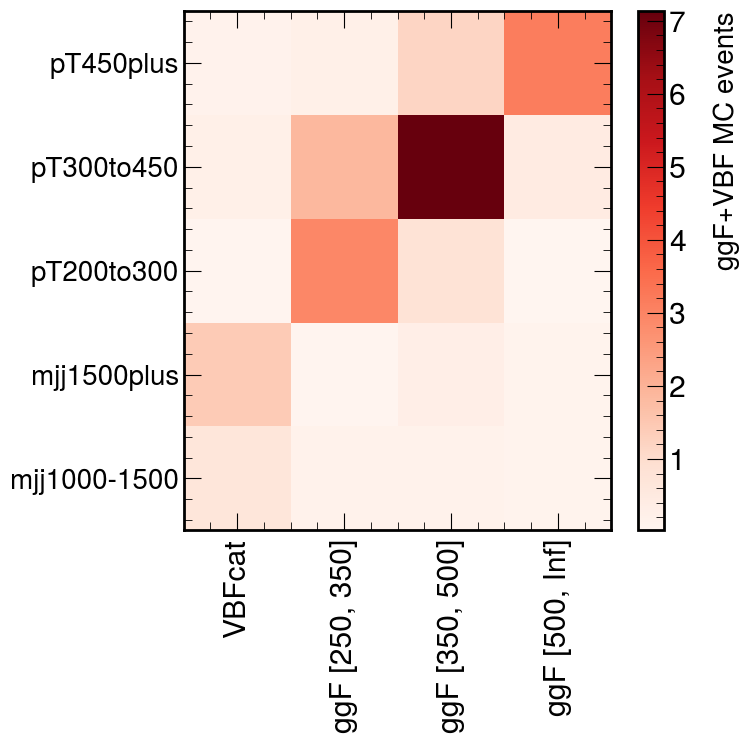

In [181]:
df["sig"]["STXS_finecat_simplified"] = -1

# VBF cats
df["sig"].loc[( (df["sig"]["STXS_finecat"] % 100 == 21) | (df["sig"]["STXS_finecat"] % 100 == 22) ), "STXS_finecat_simplified"] = 0
df["sig"].loc[( (df["sig"]["STXS_finecat"] % 100 == 23) | (df["sig"]["STXS_finecat"] % 100 == 24) ), "STXS_finecat_simplified"]= 1

# ggF cats
df["sig"].loc[( (df["sig"]["STXS_finecat"] % 100 == 1) | (df["sig"]["STXS_finecat"] % 100 == 5) ), "STXS_finecat_simplified"] = 2
df["sig"].loc[( (df["sig"]["STXS_finecat"] % 100 == 2) | (df["sig"]["STXS_finecat"] % 100 == 6) ), "STXS_finecat_simplified"] = 3
df["sig"].loc[( (df["sig"]["STXS_finecat"] % 100 == 3) | (df["sig"]["STXS_finecat"] % 100 == 7) | (df["sig"]["STXS_finecat"] % 100 == 4) | (df["sig"]["STXS_finecat"] % 100 == 8) ), "STXS_finecat_simplified"] = 4



yticks_simplified = [
    "mjj1000-1500",
    "mjj1500plus",    
    "pT200to300",
    "pT300to450",
    "pT450plus",
]

cut_mjjdeta_VBF = (df["sig"]["mjj"] > 1000) & (df["sig"]["deta"] > 3.5)
cut_mjjdeta_ggF = ~cut_mjjdeta_VBF

############ add recobins

# initialize a new column called recobin
df["sig"]["recobin"] = -1

# add VBF category index as 0
df["sig"].loc[cut_mjjdeta_VBF, "recobin"] = 0

# add ggF category index as 1,2,3
shift = 50
recobin_cut_dict = {
    "1": (250, 300 + shift),
    "2": (300 + shift, 450 + shift),
    "3": (450 + shift, 25000),
}

for index, ptcut in recobin_cut_dict.items():

    cut_pt = (df["sig"]["rec_higgs_pt"] > ptcut[0]) & (df["sig"]["rec_higgs_pt"] < ptcut[1])

    df["sig"].loc[(cut_mjjdeta_ggF & cut_pt), "recobin"] = int(index)

fig, ax = plt.subplots(figsize=(8,8))

# Create the 2D histogram
h = ax.hist2d(
    df["sig"]["recobin"],
    df["sig"]["STXS_finecat_simplified"],
    bins=(4, range(len(yticks_simplified) + 1)),
    cmap="Reds",
    weights=df["sig"]["nominal"],        
)

ax.set_xlim(0, 3)
cell_length = 3/4
bin_centers = [cell_length/2, 2*cell_length - cell_length/2, 3*cell_length - cell_length/2, 4*cell_length -cell_length/2]

ax.set_xticks(bin_centers)

ax.set_xticklabels(["VBFcat", f"ggF [250, {300+shift}]", f"ggF [{300+shift}, {450+shift}]", f"ggF [{450+shift}, Inf]"], rotation=90)

# Add a colorbar
cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label(f"ggF+VBF MC events", labelpad=20, fontsize=20)  # Label for the colorbar

ytick_positions = [i + 0.5 for i in range(len(yticks_simplified))]  # Center of each bin
ax.set_yticks(ytick_positions)
ax.set_yticklabels(yticks_simplified, fontsize=20)

plt.tight_layout()

plt.savefig("/Users/fmokhtar/Desktop/AN_2024/STXS/sig_migration_matrix_reduced.pdf")

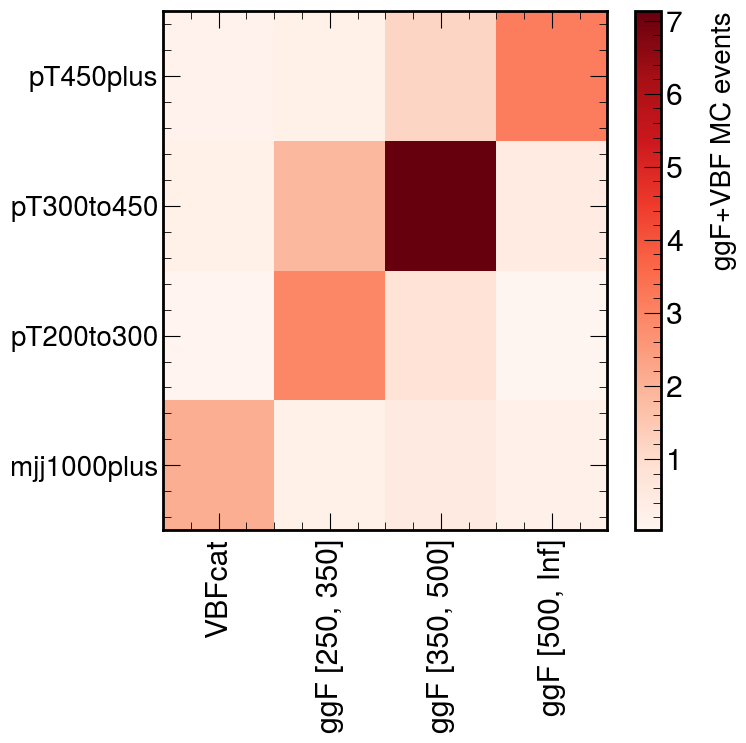

In [182]:
df["sig"]["STXS_finecat_simplified"] = -1

# VBF cats
df["sig"].loc[( (df["sig"]["STXS_finecat"] % 100 == 21) | (df["sig"]["STXS_finecat"] % 100 == 22) | (df["sig"]["STXS_finecat"] % 100 == 23) | (df["sig"]["STXS_finecat"] % 100 == 24) ), "STXS_finecat_simplified"] = 0

# ggF cats
df["sig"].loc[( (df["sig"]["STXS_finecat"] % 100 == 1) | (df["sig"]["STXS_finecat"] % 100 == 5) ), "STXS_finecat_simplified"] = 1
df["sig"].loc[( (df["sig"]["STXS_finecat"] % 100 == 2) | (df["sig"]["STXS_finecat"] % 100 == 6) ), "STXS_finecat_simplified"] = 2
df["sig"].loc[( (df["sig"]["STXS_finecat"] % 100 == 3) | (df["sig"]["STXS_finecat"] % 100 == 7) | (df["sig"]["STXS_finecat"] % 100 == 4) | (df["sig"]["STXS_finecat"] % 100 == 8) ), "STXS_finecat_simplified"] = 3


yticks_simplified = [
    "mjj1000plus",
    "pT200to300",
    "pT300to450",
    "pT450plus",
]

cut_mjjdeta_VBF = (df["sig"]["mjj"] > 1000) & (df["sig"]["deta"] > 3.5)
cut_mjjdeta_ggF = ~cut_mjjdeta_VBF

############ add recobins

# initialize a new column called recobin
df["sig"]["recobin"] = -1

# add VBF category index as 0
df["sig"].loc[cut_mjjdeta_VBF, "recobin"] = 0

# add ggF category index as 1,2,3
shift = 50
recobin_cut_dict = {
    "1": (250, 300 + shift),
    "2": (300 + shift, 450 + shift),
    "3": (450 + shift, 25000),
}

for index, ptcut in recobin_cut_dict.items():

    cut_pt = (df["sig"]["rec_higgs_pt"] > ptcut[0]) & (df["sig"]["rec_higgs_pt"] < ptcut[1])

    df["sig"].loc[(cut_mjjdeta_ggF & cut_pt), "recobin"] = int(index)

fig, ax = plt.subplots(figsize=(8,8))

# Create the 2D histogram
h = ax.hist2d(
    df["sig"]["recobin"],
    df["sig"]["STXS_finecat_simplified"],
    bins=(4, range(len(yticks_simplified) + 1)),
    cmap="Reds",
    weights=df["sig"]["nominal"],        
)

ax.set_xlim(0, 3)
cell_length = 3/4
bin_centers = [cell_length/2, 2*cell_length - cell_length/2, 3*cell_length - cell_length/2, 4*cell_length -cell_length/2]

ax.set_xticks(bin_centers)

ax.set_xticklabels(["VBFcat", f"ggF [250, {300+shift}]", f"ggF [{300+shift}, {450+shift}]", f"ggF [{450+shift}, Inf]"], rotation=90)

# Add a colorbar
cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label(f"ggF+VBF MC events", labelpad=20, fontsize=20)  # Label for the colorbar

ytick_positions = [i + 0.5 for i in range(len(yticks_simplified))]  # Center of each bin
ax.set_yticks(ytick_positions)
ax.set_yticklabels(yticks_simplified, fontsize=20)

plt.tight_layout()

plt.savefig("/Users/fmokhtar/Desktop/AN_2024/STXS/sig_migration_matrix_reduced_more.pdf")